# Introduction

Sentiment analysis is a natural language processing (NLP) task that involves determining the sentiment behind a text. It is often used to analyze reviews, social media comments, and other textual data to classify opinions as positive, negative, or neutral. In this notebook, we implement a sentiment analysis model using a Bidirectional Long Short-Term Memory (BiLSTM) network, which is well-suited for capturing the context from both directions in a sequence of words.

This notebook covers the following steps: <br>
Data Loading: Load the sentiment analysis dataset. <br>
Data Preprocessing: Clean and preprocess the text data for model training.<br>
Model Building: Build a Bidirectional LSTM model using TensorFlow/Keras.<br>
Model Training: Train the model on the preprocessed data.<br>
Model Evaluation: Evaluate the model's performance on the test data.<br>
Prediction: Make predictions on new data using the trained model.<br>

The dataset is taken from kaggle <a href='https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews' target='_blank'>here</a>.

# Importing Libraries

In [1]:
!pip install scikit-learn==1.2.2 scikeras
!pip install nltk

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Check for missing values
print(df.isnull().sum())

# Fill missing values or drop rows
df.dropna(inplace=True)

# Check if the data is balanced
print(df['sentiment'].value_counts())

# Convert labels to numeric
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  


INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


2024-08-12 18:36:02.633052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 18:36:02.633154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 18:36:02.890690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


review       0
sentiment    0
dtype: int64
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


# Data Pre-processing

This includes:

1. Convert to Lowercase
2. Removal of URLs and HTML tags
3. Remove Punctuation
4. Stemming and Lemmatization



In [2]:
print(nltk.data.path
)
nltk.download('omw-1.4')   
nltk.download('wordnet')
nltk.download('stopwords') 
nltk.download('punkt')     
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/



# Text preprocessing functions
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs and HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Stemming and Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in text.split()])
    return text

df['review'] = df['review'].apply(preprocess_text)


['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
df

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49995,thought movi right good job wasnt creativ orig...,1
49996,bad plot bad dialogu bad act idiot direct anno...,0
49997,cathol taught parochi elementari school nun ta...,0
49998,im go disagre previou comment side maltin one ...,0


In [4]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Padding sequences
max_len = max([len(x) for x in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Load GloVe embeddings
embedding_index = {}
with open('/kaggle/input/glovevec/glove.6B.100d.txt', 'r') as file:
    for line in file:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.array(values[1:], dtype='float32')

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=42)


# Model Building

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))  
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))  
    model.add(Dense(16, activation='relu'))  
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Model Training

In [6]:
import tensorflow as tf
print(tf.__version__)

model = create_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=12,
    epochs=15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)


2.15.0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 488s 144ms/step - accuracy: 0.6390 - loss: 0.6296 - val_accuracy: 0.7997 - val_loss: 0.4347
Epoch 2/15
1806/3334 ━━━━━━━━━━━━━━━━━━━━ 3:17 130ms/step - accuracy: 0.7975 - loss: 0.4552

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3334/3334 ━━━━━━━━━━━━━━━━━━━━ 482s 144ms/step - accuracy: 0.8030 - loss: 0.4460 - val_accuracy: 0.8411 - val_loss: 0.3732
Epoch 3/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 494s 148ms/step - accuracy: 0.8401 - loss: 0.3785 - val_accuracy: 0.8534 - val_loss: 0.3411
Epoch 4/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 513s 154ms/step - accuracy: 0.8559 - loss: 0.3520 - val_accuracy: 0.8621 - val_loss: 0.3284
Epoch 5/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 502s 150ms/step - accuracy: 0.8626 - loss: 0.3323 - val_accuracy: 0.8578 - val_loss: 0.3259
Epoch 6/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 477s 143ms/step - accuracy: 0.8728 - loss: 0.3122 - val_accuracy: 0.8690 - val_loss: 0.3066
Epoch 7/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 474s 142ms/step - accuracy: 0.8810 - loss: 0.2998 - val_accuracy: 0.8613 - val_loss: 0.3135
Epoch 8/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 476s 143ms/step - accuracy: 0.8886 - loss: 0.2825 - val_accuracy: 0.8604 - val_loss: 0.3164
Epoch 9/15
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 479s 144ms/step - accuracy: 0.8

In [7]:
import os

try:
    model.save('/kaggle/working/my_model.h5')
    print("Model saved successfully.")
except Exception as e:
    print(f"An error occurred: {e}")




Model saved successfully.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model


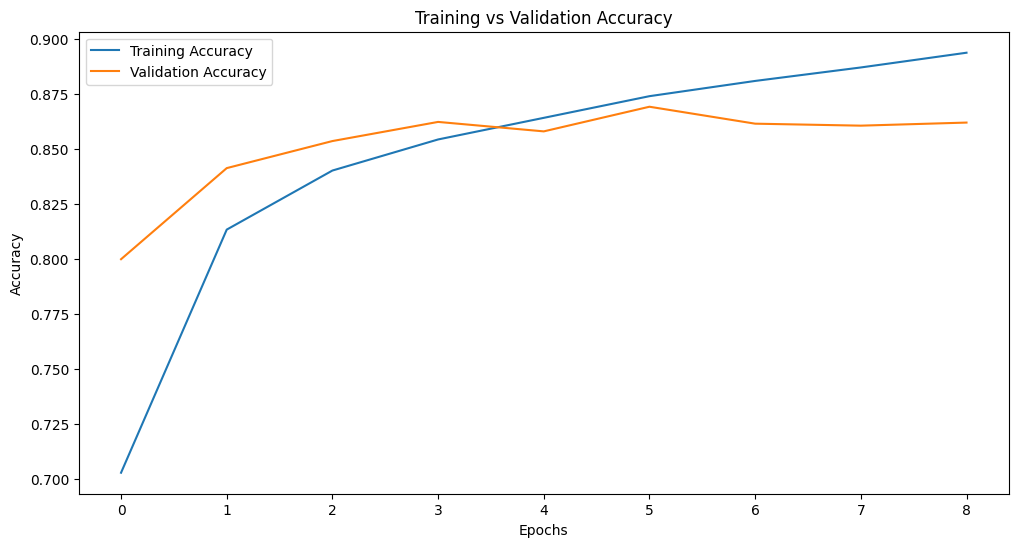

In [9]:
model = load_model('my_model.h5')

# Assuming your training history is available in the history object
history = history.history

# Plotting Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

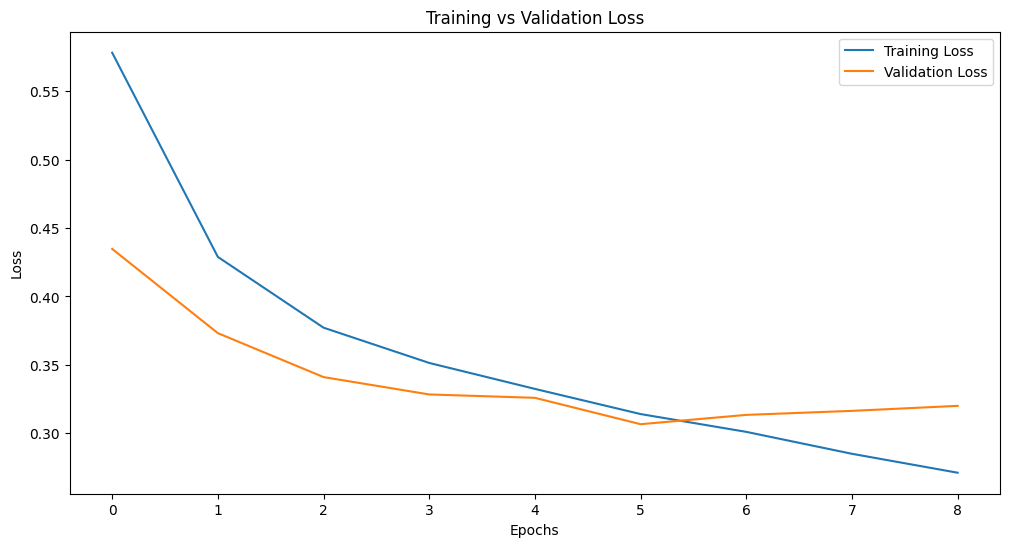

In [10]:
# Plotting Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step


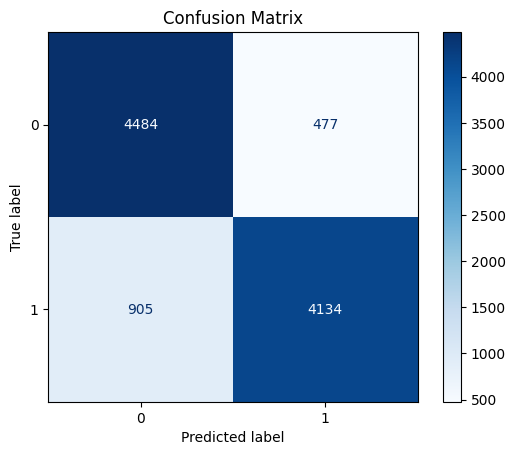

In [12]:
# Predicting on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  
y_true = y_test  

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=['Negative', 'Positive'])
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.90      0.87      4961
    Positive       0.90      0.82      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



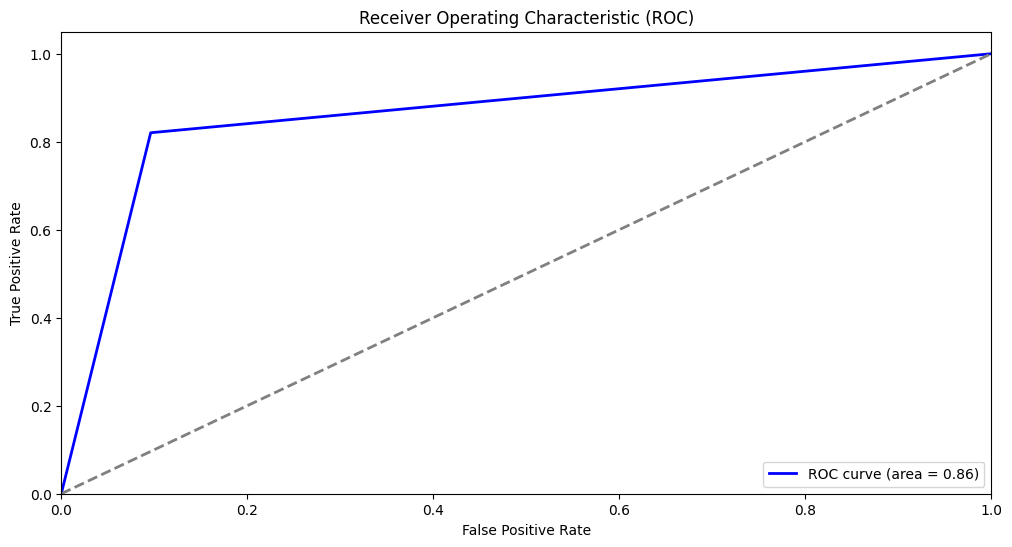

In [14]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

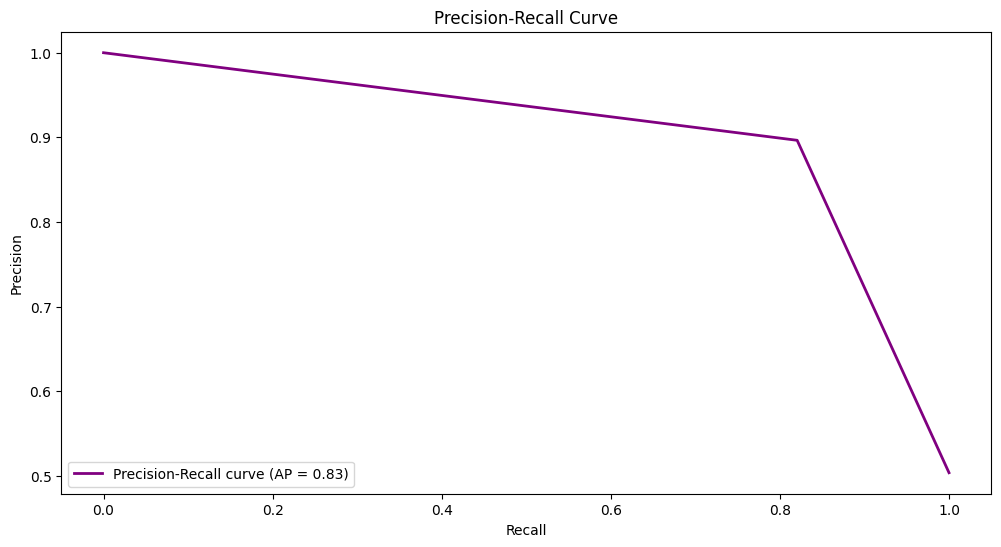

In [15]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_classes)
average_precision = average_precision_score(y_true, y_pred_classes)
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

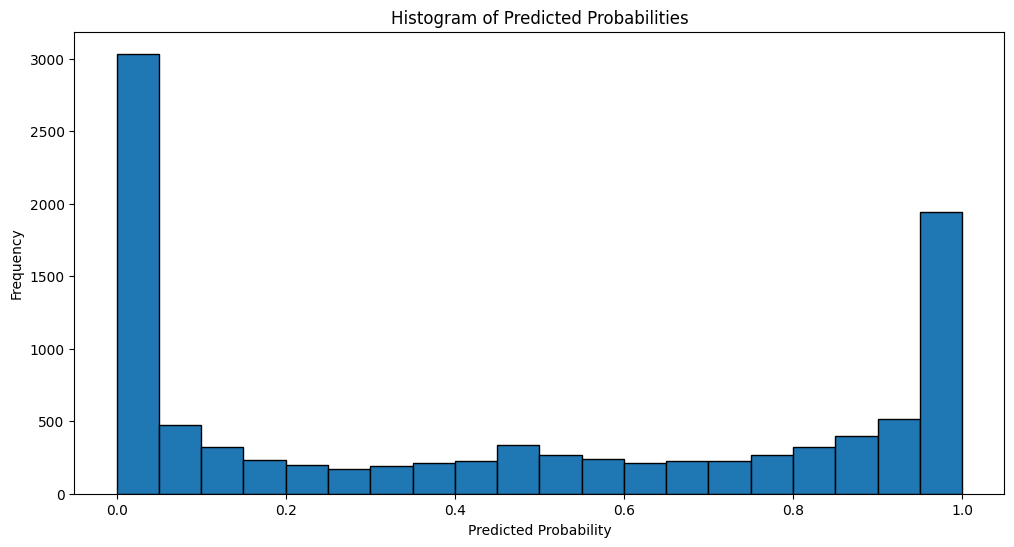

In [16]:
# Histogram of Predicted Probabilities
plt.figure(figsize=(12, 6))
plt.hist(y_pred, bins=20, edgecolor='k')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_34/1639343958.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true = y_true.ravel()  # Flatten the array if it's not 1D


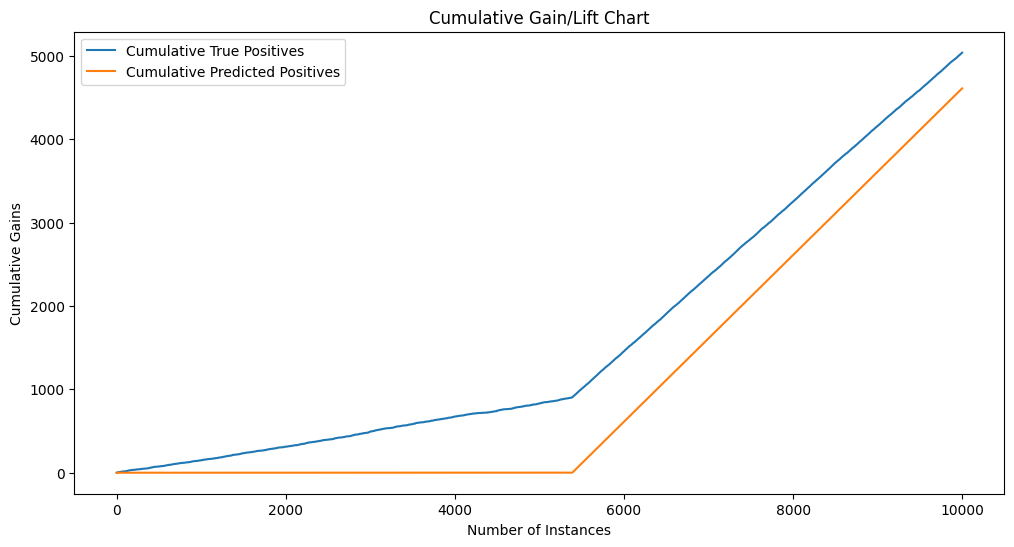

In [18]:
# Assuming y_true and y_pred_classes are 1D arrays
y_true = y_true.ravel()  
y_pred_classes = y_pred_classes.ravel()  

# Sort by predicted probabilities or predicted classes
sorted_indices = np.argsort(y_pred_classes)
sorted_true = y_true[sorted_indices]

# Cumulative sum of true positives (assuming binary classification with labels 0 and 1)
cum_true = np.cumsum(sorted_true)

# For binary classification, cumulative predicted positives

cum_pred = np.cumsum(y_pred_classes[sorted_indices])

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_true)), cum_true, label='Cumulative True Positives')
plt.plot(np.arange(len(y_true)), cum_pred, label='Cumulative Predicted Positives')
plt.title('Cumulative Gain/Lift Chart')
plt.xlabel('Number of Instances')
plt.ylabel('Cumulative Gains')
plt.legend()
plt.show()
